# Pulsar Star Classification

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration

In [2]:
df = pd.read_csv('data/train.csv').drop(['id'], axis=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Mean_Integrated       117564 non-null  float64
 1   SD                    117564 non-null  float64
 2   EK                    117564 non-null  float64
 3   Skewness              117564 non-null  float64
 4   Mean_DMSNR_Curve      117564 non-null  float64
 5   SD_DMSNR_Curve        117564 non-null  float64
 6   EK_DMSNR_Curve        117564 non-null  float64
 7   Skewness_DMSNR_Curve  117564 non-null  float64
 8   Class                 117564 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 8.1 MB


We have to develop a model to classify whether an observation is a pulsar star or not. So, we have to predict the target variable 'Class' by given the probability of the observation being a pulsar star. In order to do that, we have to understand the data first.

We have the following features in the dataset:

- Mean_Integrated: Mean of the integrated profile.
- SD: Standard deviation of the integrated profile.
- EK: Excess kurtosis of the integrated profile.
- Skewness: Skewness of the integrated profile.
- Mean_DMSNR_Cruve: Mean of the DM-SNR curve.
- SD_DMSNR_Curve: Standard deviation of the DM-SNR curve.
- EK_DMSNR_Curve: Excess kurtosis of the DM-SNR curve.
- Skewness_DMSNR_Curve: Skewness of the DM-SNR curve.
- Class (target): Class variable (0 for non pulsar star, 1 for pulsar star)

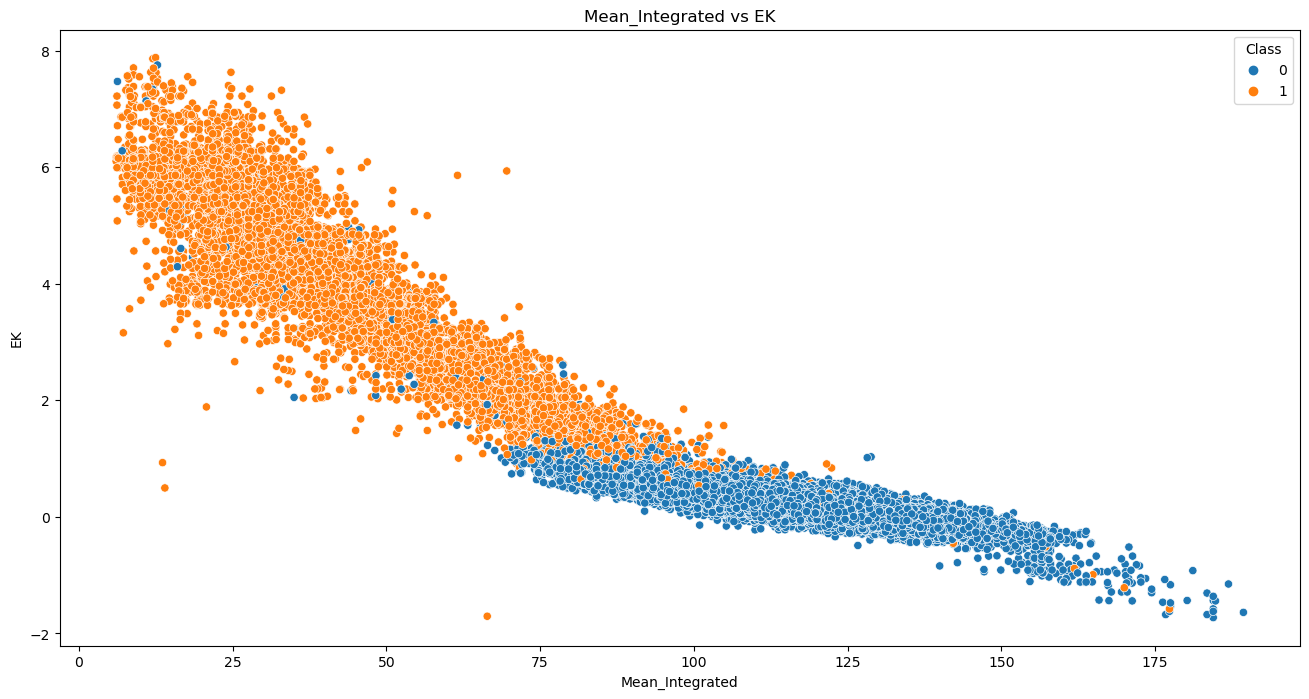

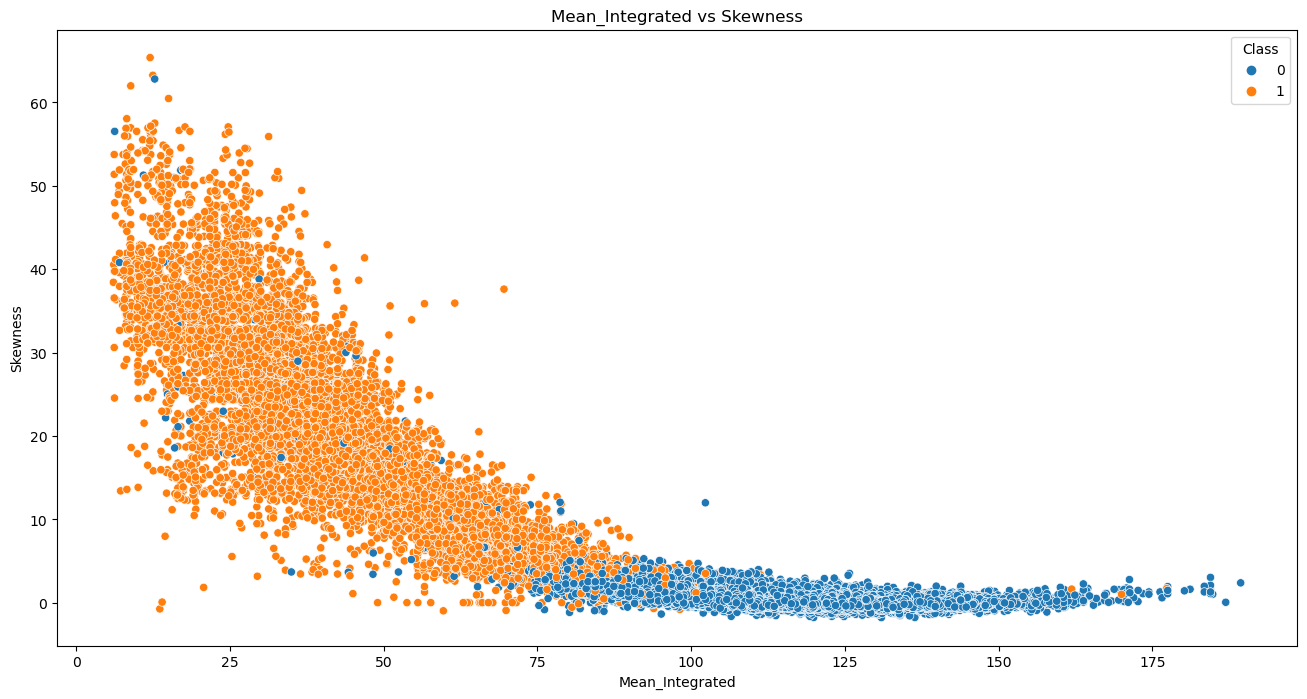

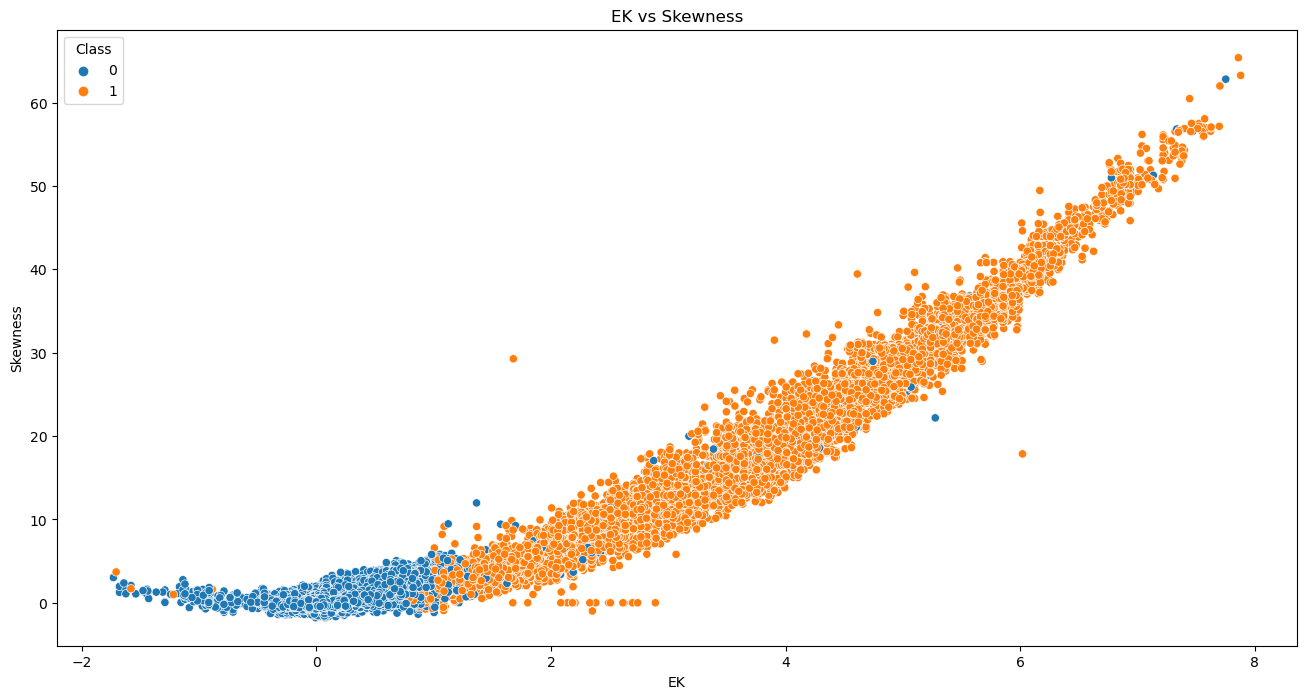

In [8]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x='Mean_Integrated', y='EK', hue='Class', data=df)
plt.title('Mean_Integrated vs EK')

plt.figure(figsize=(16, 8))
sns.scatterplot(x='Mean_Integrated', y='Skewness', hue='Class', data=df)
plt.title('Mean_Integrated vs Skewness')

plt.figure(figsize=(16, 8))
sns.scatterplot(x='EK', y='Skewness', hue='Class', data=df)
plt.title('EK vs Skewness')

plt.show()



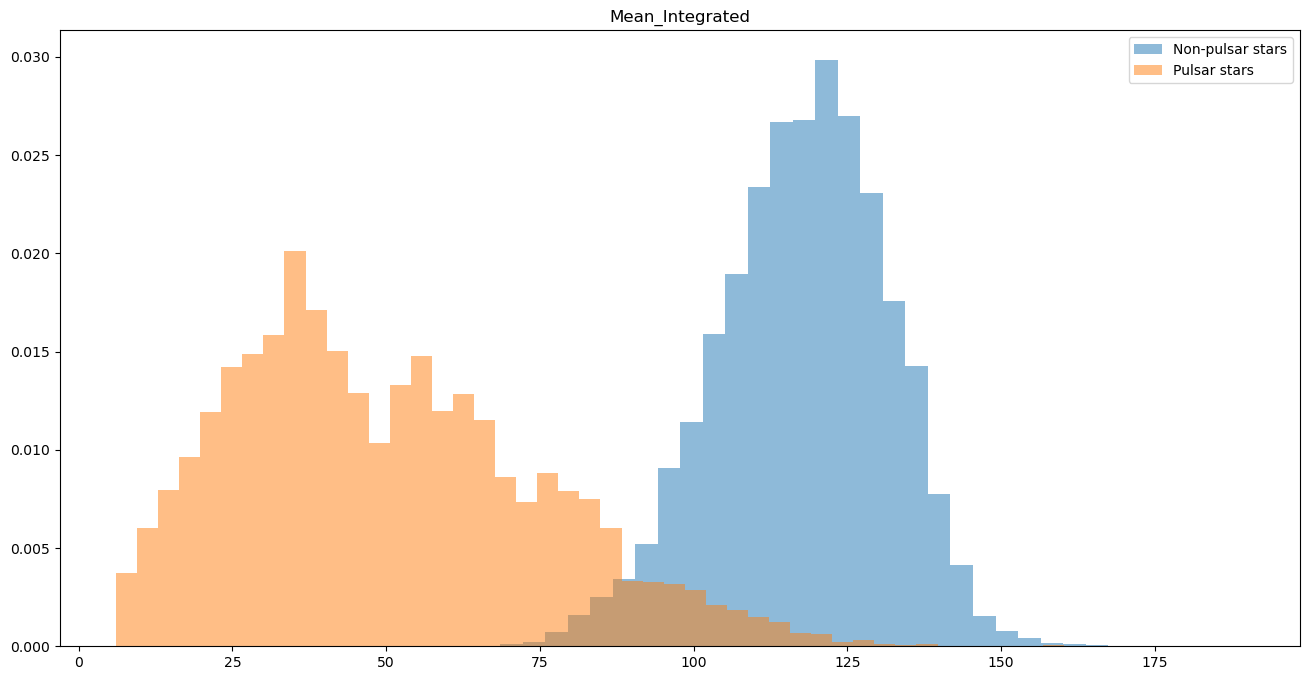

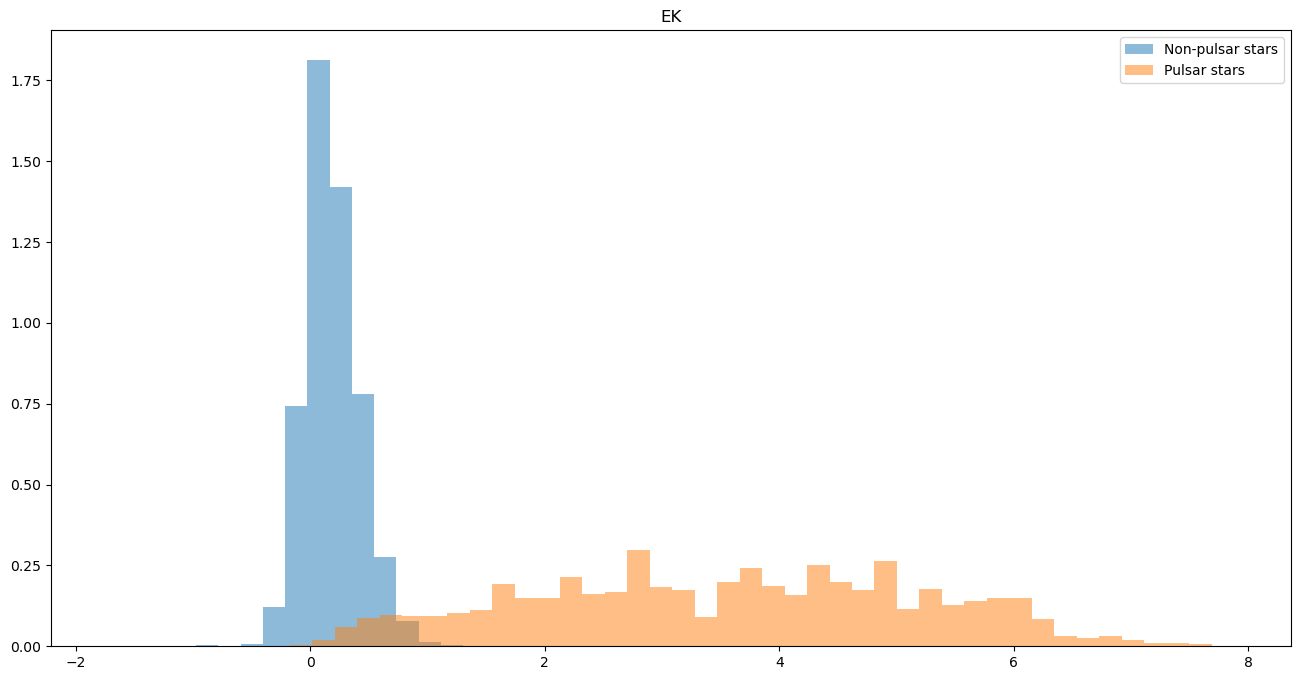

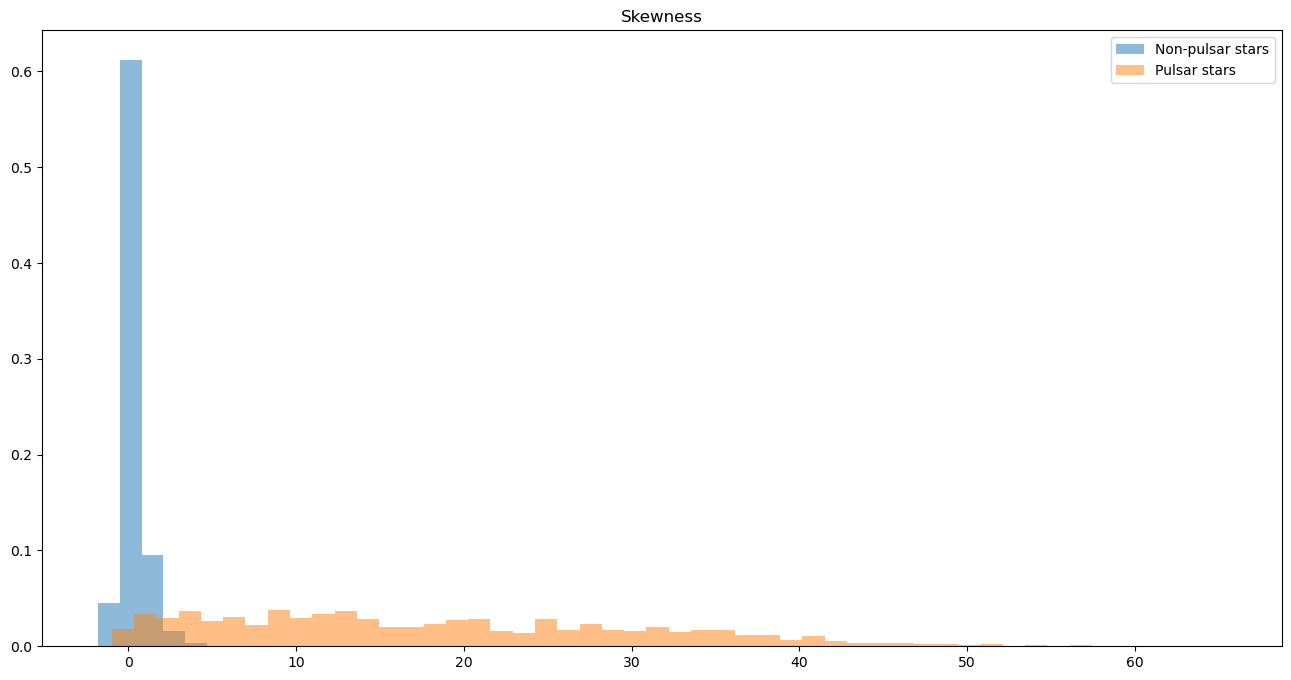

In [269]:
#check the distribution of mean_integrated, EK, Skewness distinguishing between pulsar stars and non-pulsar stars by color

plt.figure(figsize=(16, 8))
plt.hist(df[df['Class']==0]['Mean_Integrated'], bins=50, alpha=0.5, label='Non-pulsar stars',density=True)
plt.hist(df[df['Class']==1]['Mean_Integrated'], bins=50, alpha=0.5, label='Pulsar stars',density=True)
plt.title('Mean_Integrated')
plt.legend()

plt.figure(figsize=(16, 8))
plt.hist(df[df['Class']==0]['EK'], bins=50, alpha=0.5, label='Non-pulsar stars',density=True)
plt.hist(df[df['Class']==1]['EK'], bins=50, alpha=0.5, label='Pulsar stars',density=True)
plt.title('EK')
plt.legend()

plt.figure(figsize=(16, 8))
plt.hist(df[df['Class']==0]['Skewness'], bins=50, alpha=0.5, label='Non-pulsar stars',density=True)
plt.hist(df[df['Class']==1]['Skewness'], bins=50, alpha=0.5, label='Pulsar stars',density=True)
plt.title('Skewness')
plt.legend()

plt.show()


In [9]:
#split the data into train and validation set, take into account the imbalance of the data
from sklearn.model_selection import train_test_split
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Development

From the data exploration we can see that the data is not balanced. We have more non-pulsar stars than pulsar stars. So, we have to use a metric that is not affected by the imbalance of the data. We will use Log Loss as the metric for the model. Log Loss is a metric that is used for evaluating the performance of a classification model. It is a loss function that penalizes the model for being too confident about the wrong predictions. The lower the log loss, the better the model is. The log loss is calculated as follows:

$$LogLoss = -\frac{1}{N}\sum_{i=1}^{N}y_ilog(p_i) + (1-y_i)log(1-p_i)$$

where $N$ is the number of observations, $y_i$ is the actual value of the target variable, and $p_i$ is the predicted probability of the target variable.

I will use Random Forest to build the model.



In [300]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42,criterion = 'log_loss',n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', n_jobs=-1, random_state=42)

In [301]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_log_loss', n_jobs=-1)
print('Log Loss: ', -scores.mean())

Log Loss:  0.0639922384861408


In [303]:
#f1 score
from sklearn.metrics import f1_score
y_pred = rf.predict(X_val)
print('F1 score: ', f1_score(y_val, y_pred))
y_pred = rf.predict(X_train)
print('F1 score: ', f1_score(y_train, y_pred))
# Log Loss
from sklearn.metrics import log_loss
y_pred = rf.predict_proba(X_val)
print('Log Loss: ', log_loss(y_val, y_pred))
y_pred = rf.predict_proba(X_train)
print('Log Loss: ', log_loss(y_train, y_pred))

F1 score:  0.9458197104156936
F1 score:  0.999943010201174
Log Loss:  0.0685681418363462
Log Loss:  0.006229385569005248


# Fine Tuning

In [213]:
# Grid Search

from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [12],
    'n_estimators': [600],
    'max_features': ['sqrt'],
}
rf = RandomForestClassifier(random_state=42,criterion = 'log_loss', n_jobs=-1)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_log_loss')
grid_search.fit(X_train, y_train, sample_weight=np.where(y_train==0, 1, 3))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='log_loss', n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [12],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [600]},
             scoring='neg_log_loss', verbose=2)

In [214]:
grid_search.best_params_

{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 600}

In [271]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=700, random_state=42,criterion = 'log_loss', max_depth=12,n_jobs=-1)

In [272]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_log_loss', n_jobs=-1, verbose=1)
print('Log Loss: ', -scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log Loss:  0.032304684679418404


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


In [280]:
#f1 score
from sklearn.metrics import f1_score
rf.fit(X_train, y_train, sample_weight=np.where(y_train==0, 1, 5))
y_pred = rf.predict(X_val)
print('F1 score: ', f1_score(y_val, y_pred))
y_pred = rf.predict(X_train)
print('F1 score: ', f1_score(y_train, y_pred))
#Log Loss score
from sklearn.metrics import log_loss
y_pred = rf.predict_proba(X_val)[:,1]
print('Log Loss: ', log_loss(y_val, y_pred))
y_pred = rf.predict_proba(X_train)[:,1]
print('Log Loss: ', log_loss(y_train, y_pred))

F1 score:  0.9489420423183074
F1 score:  0.9771444856084355
Log Loss:  0.03438626339864494
Log Loss:  0.016844786896833136


# Evaluation on Test Data


In [151]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,117564,140.046875,54.507800,0.058862,-0.567263,2.337793,14.868335,9.591760,117.988781
1,117565,107.828125,51.578965,0.284368,-0.338430,1.574415,12.501437,11.694968,182.704822
2,117566,135.062500,49.812343,-0.087784,-0.094341,3.576923,21.243336,7.252386,59.021499
3,117567,112.812500,41.926647,0.519921,1.287762,6.669732,29.013153,5.097661,27.105240
4,117568,96.210938,35.322620,0.481286,2.443080,2.218227,17.041064,9.766006,117.131775


In [275]:
y_pred = rf.predict_proba(df_test.drop(['id'], axis=1))[:,1]
df_pred = pd.DataFrame({'id':df_test['id'], 'Class':y_pred})
df_pred.head()

,id,Class
0,117564,0.000027
1,117565,0.004177
2,117566,0.000110
3,117567,0.148573
4,117568,0.009170


In [276]:
df_pred.to_csv('submission.csv', index=False)

<Axes: >

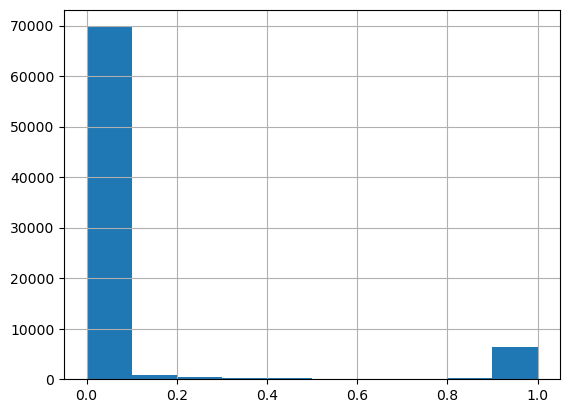

In [157]:
df_pred['Class'].hist()

# XGBoost

Let's try using XGBoost to see if we can get a better result.

In [304]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42, n_jobs=-1,verbosity=1)

In [305]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring='neg_log_loss', n_jobs=-1, verbose=1)
print('Log Loss: ', -scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log Loss:  0.033164949282730345


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.8s finished


In [306]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [307]:
#f1 score
from sklearn.metrics import f1_score
y_pred = xgb.predict(X_val)
print('F1 score: ', f1_score(y_val, y_pred))
y_pred = xgb.predict(X_train)
print('F1 score: ', f1_score(y_train, y_pred))
# Log Loss score
from sklearn.metrics import log_loss
y_pred = xgb.predict_proba(X_val)[:,1]
print('Log Loss: ', log_loss(y_val, y_pred))
y_pred = xgb.predict_proba(X_train)[:,1]
print('Log Loss: ', log_loss(y_train, y_pred))

F1 score:  0.9484440315838365
F1 score:  0.9796928033135822
Log Loss:  0.033534155890386344
Log Loss:  0.012311573517599412


# CatBoost

In [75]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_state=42,verbose=1,loss_function='Logloss',eval_metric='Logloss',max_depth=3)


In [76]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(cat, X_train, y_train, cv=10, scoring='neg_log_loss', n_jobs=-1, verbose=1)
print('Log Loss: ', -scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Learning rate set to 0.071854
0:	learn: 0.5332174	total: 238ms	remaining: 3m 46s
1:	learn: 0.4106669	total: 433ms	remaining: 3m 25s
2:	learn: 0.3160811	total: 655ms	remaining: 3m 26s
3:	learn: 0.2388023	total: 734ms	remaining: 2m 53s
4:	learn: 0.1897438	total: 982ms	remaining: 3m 5s
5:	learn: 0.1523515	total: 1.11s	remaining: 2m 55s
6:	learn: 0.1281383	total: 1.41s	remaining: 3m 9s
7:	learn: 0.1061356	total: 1.63s	remaining: 3m 12s
8:	learn: 0.0922822	total: 1.77s	remaining: 3m 4s
9:	learn: 0.0805331	total: 1.98s	remaining: 3m 5s
10:	learn: 0.0729784	total: 2.18s	remaining: 3m 6s
11:	learn: 0.0656675	total: 2.38s	remaining: 3m 6s
12:	learn: 0.0613613	total: 2.66s	remaining: 3m 11s
13:	learn: 0.0569349	total: 2.84s	remaining: 3m 10s
14:	learn: 0.0541030	total: 3.07s	remaining: 3m 11s
15:	learn: 0.0516737	total: 3.21s	remaining: 3m 7s
16:	learn: 0.0499633	total: 3.37s	remaining: 3m 4s
17:	learn: 0.0480735	total: 3.56s	remaining: 3m 4s
18:	learn: 0.0463766	total: 3.58s	remaining: 2m 55s
1

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


In [52]:
cat.fit(X_train, y_train)

Learning rate set to 0.049441
0:	learn: 0.5793697	total: 5.12ms	remaining: 7.68s
1:	learn: 0.4840658	total: 9.02ms	remaining: 6.76s
2:	learn: 0.4004990	total: 13.2ms	remaining: 6.59s
3:	learn: 0.3300439	total: 17.9ms	remaining: 6.7s
4:	learn: 0.2778421	total: 22.5ms	remaining: 6.71s
5:	learn: 0.2381309	total: 26.9ms	remaining: 6.69s
6:	learn: 0.2040710	total: 31.5ms	remaining: 6.72s
7:	learn: 0.1784112	total: 36.3ms	remaining: 6.76s
8:	learn: 0.1537757	total: 41.1ms	remaining: 6.8s
9:	learn: 0.1356425	total: 45.4ms	remaining: 6.76s
10:	learn: 0.1206079	total: 49.8ms	remaining: 6.74s
11:	learn: 0.1076709	total: 54.5ms	remaining: 6.76s
12:	learn: 0.0966794	total: 58.4ms	remaining: 6.68s
13:	learn: 0.0885354	total: 62.5ms	remaining: 6.64s
14:	learn: 0.0810186	total: 66.4ms	remaining: 6.58s
15:	learn: 0.0760972	total: 70.2ms	remaining: 6.51s
16:	learn: 0.0714571	total: 74ms	remaining: 6.46s
17:	learn: 0.0674860	total: 77.6ms	remaining: 6.39s
18:	learn: 0.0638700	total: 81.2ms	remaining: 6.

In [53]:
#f1 score
from sklearn.metrics import f1_score
y_pred = cat.predict(X_val)
print('F1 score: ', f1_score(y_val, y_pred))
y_pred = cat.predict(X_train)
print('F1 score: ', f1_score(y_train, y_pred))
# Log Loss score
from sklearn.metrics import log_loss
y_pred = cat.predict_proba(X_val)[:,1]
print('Log Loss: ', log_loss(y_val, y_pred))
y_pred = cat.predict_proba(X_train)[:,1]
print('Log Loss: ', log_loss(y_train, y_pred))

F1 score:  0.9489867225716283
F1 score:  0.95791978640664
Log Loss:  0.031248013538568157
Log Loss:  0.02752491450654927


In [30]:
cat.fit(X, y)

Learning rate set to 0.078875
0:	learn: 0.5083494	total: 5.08ms	remaining: 5.08s
1:	learn: 0.3646876	total: 10.1ms	remaining: 5.05s
2:	learn: 0.2805957	total: 15ms	remaining: 5s
3:	learn: 0.2085871	total: 19.9ms	remaining: 4.96s
4:	learn: 0.1620037	total: 24.9ms	remaining: 4.95s
5:	learn: 0.1299142	total: 29.7ms	remaining: 4.92s
6:	learn: 0.1071035	total: 34.6ms	remaining: 4.91s
7:	learn: 0.0920734	total: 40.2ms	remaining: 4.98s
8:	learn: 0.0802714	total: 45.1ms	remaining: 4.96s
9:	learn: 0.0714800	total: 49.9ms	remaining: 4.94s
10:	learn: 0.0651058	total: 54.6ms	remaining: 4.91s
11:	learn: 0.0603399	total: 59.5ms	remaining: 4.89s
12:	learn: 0.0564116	total: 64ms	remaining: 4.86s
13:	learn: 0.0534676	total: 68.6ms	remaining: 4.83s
14:	learn: 0.0511182	total: 72.8ms	remaining: 4.78s
15:	learn: 0.0488914	total: 77.6ms	remaining: 4.77s
16:	learn: 0.0463995	total: 82ms	remaining: 4.74s
17:	learn: 0.0450958	total: 86.4ms	remaining: 4.72s
18:	learn: 0.0438444	total: 91.1ms	remaining: 4.71s
1

# predictions

In [32]:
df_test = pd.read_csv('data/test.csv')
y_pred = cat.predict_proba(df_test.drop(['id'], axis=1))[:,1]
df_pred = pd.DataFrame({'id':df_test['id'], 'Class':y_pred})
df_pred.head()

,id,Class
0,117564,0.000046
1,117565,0.001109
2,117566,0.000201
3,117567,0.056971
4,117568,0.001904


In [33]:
df_pred.to_csv('submission.csv', index=False)

# Feature Engineering